# VAEVE internship - Data Anlysis - Santiago

## 1. Data extraction
First step is aggroupating all data obtained from DeepEthogram (DEG) analysis and manual annotation. The input is in **DEG format** :
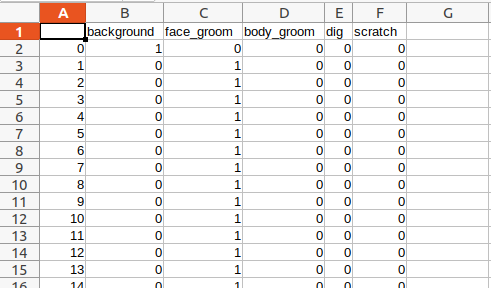

The script charged to do this is "extract_data.py".

In [ ]:
import os
import pandas as pd
from moviepy.editor import VideoFileClip
import re
from datetime import datetime as dtt

def get_video_duration(file):
    video_dir = file.replace("_outputs_labels_predictions.csv", "")

    video_filename = file.replace("_outputs_labels_predictions.csv", ".mp4")
    video_path = os.path.join(r"D:\LBN\Maternal_auto_classification_TS7_deepethogram\DATA", video_dir ,video_filename)

    try:
        clip = VideoFileClip(video_path)
        return round(clip.duration, 2)
    except Exception as e:
        print(f"❌ Erreur lecture vidéo {video_path}: {e}")
        

def remove_spaces_in_filenames_and_folders(root_folder):
    # Primero renombrar archivos en todos los subdirectorios
    for foldername, subfolders, filenames in os.walk(root_folder, topdown=False):
        # Renombrar archivos
        for filename in filenames:
            if " " in filename:
                old_path = os.path.join(foldername, filename)
                new_filename = filename.replace(" ", "")
                new_path = os.path.join(foldername, new_filename)
                os.rename(old_path, new_path)
                print(f"Renamed file: '{old_path}' to '{new_path}'")
        # Renombrar carpetas
        if " " in os.path.basename(foldername):
            old_folder_path = foldername
            new_folder_name = os.path.basename(foldername).replace(" ", "")
            new_folder_path = os.path.join(os.path.dirname(foldername), new_folder_name)
            os.rename(old_folder_path, new_folder_path)
            print(f"Renamed folder: '{old_folder_path}' to '{new_folder_path}'")

def extract() : 
    # Le dossier racine qui contient les sous-dossiers
    root_data_folder = r"Maternal_auto_classification_TS7_deepethogram\maternal_behaviour_results"

    remove_spaces_in_filenames_and_folders(root_data_folder)

    final_columns = ["frame", "background", "Onnest", "Offnest", "ABN", "Carryingpups",
                    "Selfgrooming", "Eat_drink", "Kicking", "Groomingpups", "Build",
                    "Cage", "LBN", "Recording_duration", "Start_time",
                    "Nest_entry", "Nest_exits"]

    all_data = []

    for subdir, _, files in os.walk(root_data_folder):
        for file in files:
            if file.endswith("outputs_labels_predictions.csv") :
                csv_path = os.path.join(subdir, file)

                # match = re.match(r"Cage([A-Z0-9]+)-(LBN|CONT)-([\d\-]+_[\d\-]+)_labels\.csv", file)
                match = re.match(r"Cage([A-Z0-9]+)-(LBN|CONT)-([\d\-]+_[\d\-]+)_outputs_labels_predictions\.csv", file)

                if not match:
                    match = re.match(r"(LBN|CONT)?-([\d\-]+_[\d\-]+)", file)

                    if match:
                        group, start_time = match.groups()
                        cage = "G" if group == "CONT" else "E"
                        lbn = bool(group == "CONT")
                    else :
                        print(f"❌ Nom de fichier inattendu: {file}")
                        continue
                else : 
                    cage = match.group(1)
                    lbn = bool(match.group(2))
                    start_time = match.group(3)

                start_time = start_time.replace("_", "T")  # Reemplazamos el guion bajo por la T

                # Convertimos la cadena al formato datetime
                start_time = dtt.strptime(start_time, "%Y-%m-%dT%H-%M-%S")
                start_time = start_time.strftime("%Y-%m-%dT%H:%M:%S")


                # Ahora puedes usar strftime para obtener el formato est


                # === Chargement du CSV ===
                df = pd.read_csv(csv_path)
                df.insert(0, 'frame', range(len(df)))
                df.iloc[0] = 0
                df = df.rename(columns={df.columns[0]: "frame"})  # renomme première colonne en 'frame'

                duration = get_video_duration(file)

                # === Ajout des colonnes constantes ===
                df["Cage"] = cage
                df["LBN"] = lbn
                df["Recording_duration"] = duration
                df["Start_time"] = start_time

                df["Nest_entry"] = 0
                df["Nest_exits"] = 0

                # On commence à la 1re frame pour pouvoir regarder la précédente
                for i in range(1, len(df)):
                    prev_onnest = df.loc[i - 1, "Onnest"]
                    prev_offnest = df.loc[i - 1, "Offnest"]
                    curr_onnest = df.loc[i, "Onnest"]
                    curr_offnest = df.loc[i, "Offnest"]

                    # Nest entry detection
                    if (
                        prev_offnest == 1 and curr_onnest == 1 
                    ):
                        df.loc[i, "Nest_entry"] = 1

                    # Nest exit detection
                    if (
                        prev_onnest == 1  and curr_offnest == 1
                    ):
                        df.loc[i, "Nest_exits"] = 1


                # Réorganiser les colonnes
                df = df[final_columns]

                all_data.append(df)

    metadata = pd.read_csv(r"D:\LBN\pups_data\juvenile\metadatafile-juvenile-all.csv", sep=";")
    final_df = pd.concat(all_data, ignore_index=True)

    metadata["Cage ID"] = metadata["Cage ID"].astype(str).str.strip()
    metadata["PupID"] = metadata["PupID"].astype(str).str.strip()

    # Fusionner avec le final_df
    final_df["Cage"] = final_df["Cage"].astype(str).str.strip()

    # Faire la jointure (merge) sur les cages
    merged_df = final_df.merge(metadata, left_on="Cage", right_on="Cage ID", how="left")

    print("✅ DataFrame final créé avec ", len(merged_df), " lignes.")

    merged_df.to_csv("maternal_data/behavioural_annotation.csv", index=False)

    return "behavioural_annotation.csv"

datafile= extract()

❌ Nom de fichier inattendu: Cage1-LBN-2024-08-31_06-14-40-stereotypie_outputs_labels_predictions.csv
✅ DataFrame final créé avec  35509836  lignes.


## Data transforming
Once the data has been placed on 'behavioural_annotation.csv" by the last cell, we can start by doing the first data extraction and transformation. We are going to define an LBN  session by using the "LbnSession" class. This session will be defined by the **cages**, the **start and end time*.

For this analysis, we'll be exploring all the pups 

In [2]:
from classes.LbnSession import LbnSessions
from datetime import datetime
import pandas as pd
import json
import numpy as np

allCages = pd.read_csv("behavioural_annotation.csv")
allCages["Cage"] = allCages["Cage"].astype(str).str.strip()
allCages = allCages["Cage"].unique().tolist()
allCages = [cage for cage in allCages if cage != "K2"]
print(allCages)
dataFile = r"D:\LBN\behavioural_annotation.csv"

session = LbnSessions(cage=allCages, startDate=datetime(2024,7,5), endDate=datetime(2025,7,6))

C:\Users\TeamGranon\AppData\Local\Temp\ipykernel_16084\410113810.py:7: DtypeWarning: Columns (11,17,18,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  allCages = pd.read_csv("behavioural_annotation.csv")


['1', '2', '3', '6', '7', '8', '9', 'A', 'C', 'D', 'K1']


We extract then some data. First a "resultados.json" file that will contain general information. Then a resumeDf that will contain data by day and not by frames. Indeed, this last dataframe will regroup frame data, into only one line extracting the duration and the frequencie (bouts) of each behaviour. 

In [3]:
# jsonPath = session.exportResults()
resultDf = session.getResumedDf(getCsv=True)


Resume_df.csv
